In [1]:
library(xgboost)
library(ggplot2)
library(ROCR)
library(SHAPforxgboost)
require(Matrix)
library(tidyxl)

Loading required package: Matrix



In [2]:
source('../../model_functions.R')
source('config/config_cols_modello_v3_arr.R')

path_data <- file.path('../../../data/')


Loading required package: xlsx

Loading required package: XML

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm



## Lettura dati

In [3]:
lista_master_names <- list.files(file.path(path_data,'RDS/master/non_sme/'))

lista_master <- lapply(file.path(path_data,'RDS/master/non_sme/',lista_master_names), function(file){
    dt <- readRDS(file)
})
names(lista_master) <- gsub(".*_(.+).RDS.*", "\\1",lista_master_names)

In [4]:
master_modello <- Reduce(function(x,y) merge(x = x, y = y, by = c("NUM_PRATICA",'PROGRESS_PRATICA')),lista_master)

## fill na di CR e Bilancio

In [5]:
### FILL NA DI CR CON -1000 tanto i valori sono sempre positivi e gli infiniti CON UN numero alto 
 

cols_cr <- colnames(master_modello)[grepl("CR_",colnames(master_modello))]
master_modello[, (cols_cr) := lapply(.SD, function(x){x[is.infinite(x)] <- 9999999; x}), .SDcols = cols_cr]
master_modello[, (cols_cr) := lapply(.SD, function(x){x[is.na(x)] <- -10000; x}), .SDcols = cols_cr]

cols_XRA<- colnames(master_modello)[grepl("XRA_",colnames(master_modello))]
master_modello[, (cols_XRA) := lapply(.SD, function(x){x[is.na(x)] <- 0; x}), .SDcols = cols_XRA]

cols_bil <- colnames(master_modello)[grepl("BIL_",colnames(master_modello))]
master_modello[, (cols_bil) := lapply(.SD, function(x){x[is.infinite(x) & x>0 ] <- 9999999; x}), .SDcols = cols_bil]
master_modello[, (cols_bil) := lapply(.SD, function(x){x[is.infinite(x)] <- -9999999; x}), .SDcols = cols_bil]

In [6]:
## FILTRI A MONTE

In [7]:
master_modello_filt <- master_modello[is.na(DSI_protesti_certi) | (DSI_protesti_certi ==0) ,]
master_modello_filt <- master_modello_filt[is.na(DSI_fallimenti_certi) | (DSI_fallimenti_certi ==0) ,]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_fallimenti_dubbi) | DSI_flag_fallimenti_dubbi ==FALSE,]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_pregiudizievoli_gravi) | DSI_flag_pregiudizievoli_gravi ==FALSE,]
master_modello_filt <- master_modello_filt[is.na(DSI_procedure_imprese_collegate) | DSI_procedure_imprese_collegate =='  ',]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_procedure_concorsuali) | DSI_flag_procedure_concorsuali ==FALSE,]

n1 <- nrow(master_modello) - nrow(master_modello_filt)
n1

master_modello_filt <- master_modello_filt[DSI_flag_presenza_sofferenze != "ROSSO",]
n2 <- nrow(master_modello) - nrow(master_modello_filt) -n1
n2

master_modello_filt <- master_modello_filt[is.na(DSI_col_fido_con_causale_negativa) | DSI_col_fido_con_causale_negativa != "ROSSO",]

master_modello_filt <- master_modello_filt[is.na(DSI_col_appl_con_causale_negativa) | DSI_col_appl_con_causale_negativa != "ROSSO",]

n3 <- nrow(master_modello) - nrow(master_modello_filt) -n1 -n2

master_modello_filt <- master_modello_filt[is.na(DSI_sab) | (DSI_sab %in% c('2','3','A','non censito')) ,]



master_modello_filt <- master_modello_filt[is.na(DSI_col_presenza_pratica_pef) | DSI_col_presenza_pratica_pef != "GIALLO",]


master_modello_filt <- master_modello_filt[is.na(DSI_parte_correlata) | (DSI_parte_correlata %in% c('missing','non censito')) ,]



master_modello_filt <- master_modello_filt[is.na(FORB_PRESENZA) | FORB_PRESENZA == 0,]

master_modello_filt <- master_modello_filt[is.na(AT_cod_sett) | AT_cod_sett !='MEDIA00',]

master_modello_filt <- master_modello_filt[is.na(COD_TP_CLI),]

master_modello_filt <- master_modello_filt[is.na(COD_CARTIPO),]

master_modello_filt <- master_modello_filt[is.na(DSI_stato_societario) | DSI_stato_societario =='A  A  ATTIVA',]

[1] 968

[1] 12

In [8]:
(nrow(master_modello) - nrow(master_modello_filt))/nrow(master_modello)

[1] 0.1185738

In [9]:
master_modello_filt[,flag_exante := "NO"]
master_modello <- merge(master_modello,
                       master_modello_filt[,.(NUM_PRATICA,PROGRESS_PRATICA,flag_exante)],
                       by = c('NUM_PRATICA','PROGRESS_PRATICA'))

In [10]:
saveRDS(master_modello,'../../../data/RDS/master/master_nonsme_0606.RDS')

In [11]:
## Fill na delle altre variabili

In [12]:
master_modello_fill<- master_modello[ , lapply(.SD,function(x) ifelse((is.infinite(x)),NA,x))]

master_modello_fill<- master_modello_fill[ , lapply(.SD,function(x) ifelse((is.na(x) & class(x) %in% c("factor","character")),'missing',x))]
 
master_modello_fill <- master_modello_fill[ , lapply(.SD,function(x) ifelse((is.na(x) & (class(x) %in% c("numeric","integer"))),mean(x,na.rm = TRUE) ,x))]             #mean(x,na.rm = TRUE)                                         

table(master_modello_fill$DSI_parte_correlata,useNA = 'always')
                                           
master_modello_fill <- cbind.data.frame(lapply(master_modello_fill, function(x) {
      if (all(unique(x) %in% c(0,1)))
        as.factor(c("NO", "YES")[x+1])
      else if (all(is.character(x)))
        as.factor(x)
      else
        x
    }))
    setDT(master_modello_fill)

table(master_modello_fill$target)


#master_modello<- master_modello[,which(unlist(lapply(master_modello, function(x)!all(is.na(x))))),with=FALSE]
master_modello_fill<- master_modello_fill[,which(unlist(lapply(master_modello_fill, function(x)!all(is.na(x))))),with=FALSE]


    missing non censito        <NA> 
      28527        7615           0 


DEFAULT      OK 
    689   35453 

In [18]:
lista_vars_na <- unlist(lapply(colnames(master_modello_fill[,..cols_modello]), function(x){

    perc <- 100*nrow(master_modello_fill[is.na(get(x)),..cols_modello])/nrow(master_modello_fill[,..cols_modello])
    if(perc > 40){
#         print(x)
#         print(100*nrow(master_co[is.na(get(x)),])/nrow(master_co))
        return(x)
    }else
        return(NULL)
}))
lista_vars_na

NULL

In [13]:
lista_vars_missing <- unlist(lapply(colnames(master_modello[,..cols_modello]), function(x){

    perc <- 100*nrow(master_modello[is.na(get(x)),..cols_modello])/nrow(master_modello[,..cols_modello])
    if(perc > 40){
#         print(x)
#         print(100*nrow(master_co[is.na(get(x)),])/nrow(master_co))
        return(x)
    }else
        return(NULL)
}))
lista_vars_missing

[1] "DSI_imp_richiesto_lim_autonomia" "AT_cod_sett_cedente"            
[3] "EWS_pred"                        "FORMA_GIURIDICA"

In [14]:
## Modello

In [15]:
source('../../model_functions.R')

modello_nonsme <- compute_model(
    master_modello_fill[flag_exante == 'NO',
   # setdiff(colnames(master_modello_fill),c(lista_vars_na,cols_2rm,"flag_exante")),,with = FALSE
                       ..cols_modello], seed = 1011,
    suffix="corporate",minbuck= 0.0006, 
  # cols_2rm = c("EWS_ASIS",'CRA_ADJ'),
    use_surr =  1,perc_split = 0.80,desc = 'nonsme')

[1] 28913
[1] 7229
[1] 5


Using 'N' as value column. Use 'value.var' to override



In [16]:
train <- master_modello_fill[flag_exante == 'NO',..cols_modello][modello_nonsme$rows]
test <- master_modello_fill[flag_exante == 'NO',..cols_modello][-modello_nonsme$rows]

write.csv(train, '../non_sme/output/dt_train_co.csv')
write.csv(test, '../non_sme/output/dt_test_co.csv')

In [19]:
feat_imp <- setDT(data.frame(imp = round(modello_nonsme$model$variable.importance,4)), keep.rownames = TRUE)
colnames(feat_imp) <- c('nome_var','F_imp')

tab_variabili <- data.table(nome_var = colnames(master_modello_fill), valorizzata = !(colnames(master_modello_fill)%in%lista_vars_na))
tab_variabili <- merge(tab_variabili,
                      feat_imp,
                      by = 'nome_var',
                      all.x = TRUE)

In [20]:
tab_variabili <- tab_variabili[order(-F_imp)]
tab_variabili[,ordine_albero := (1:nrow(tab_variabili))]

In [21]:
p <- ggplot(tab_variabili[!is.na(F_imp),], aes(x=reorder(nome_var,F_imp), y=F_imp,fill=F_imp))+ 
        geom_bar(stat="identity", position="dodge")+ coord_flip()+
        ylab("Variable Importance")+
        xlab("")+
        ggtitle("Information Value Summary")+
        guides(fill=F)+
        scale_fill_gradient(low="cyan", high="blue")+
        theme(axis.text=element_text(size=16))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


In [22]:
ggsave(
    filename = paste0(
        "output/",gsub("-","",Sys.Date()),"/",
        gsub(":","",substr(Sys.time(),12,20)),"featImp_corporate.png"
    ), 
    width = 300, height = 450,
    units = "mm",
    dpi = 320,
    p
)

In [23]:
model_frame <- as.data.table(modello_nonsme$model$frame)
model_frame[,type := 'leaf']
model_frame[var != '<leaf>',type := 'other']

modello_nonsme$tree_table[,round_pred := round(as.numeric(pred_vpc),7) ]
model_frame[,round_pred := round(yval2.V4,7) ]

In [24]:
dt_tree <-unique(merge(modello_nonsme$tree_table,
                       model_frame[,c('var','type','round_pred')], 
                       by = 'round_pred',
                       all.x = TRUE))

In [25]:
dt_tree[, lift := round(prob/(sum(DEFAULT)/sum(tot)),1)]
dt_tree[, def_cumulato := cumsum(DEFAULT)]
dt_tree[, tot_cumulato := cumsum(tot)]
dt_tree[, td_cumulato := def_cumulato/tot_cumulato]
write.xlsx(dt_tree[type == "leaf",.(pred_vpc,DEFAULT,tot,def_cumulato,tot_cumulato,td_cumulato)],
           'table_foglie_V3_arr.xlsx',
           row.names = FALSE)

In [26]:
dt_sample_all <- merge(modello_nonsme$pred,dt_orig[,c('NUM_PRATICA',"PROGRESS_PRATICA",'ESITO_FINALE_VPC')],by.x = c('NUM_PRATICA',"PROGRESS_PRATICA"), by.y = c('NUM_PRATICA',"PROGRESS_PRATICA"),all.x = TRUE,
                suffixes = c("","_y"))

leaves_val <- unique(dt_tree[type != 'other', pred_vpc])
other_val <- unique(dt_tree[type == 'other', pred_vpc])
# leaves_val
# other_val

dt_sample <- dt_sample_all[pred_vpc %in% leaves_val,]

In [27]:
performance_oldvpc(dt_sample)

colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,52,3401,3453,1.506,47.766
GIALLO,38,3048,3086,1.231,42.689
ROSSO,26,664,690,3.768,9.545


In [28]:
# dt_sample_limsoc <- merge(dt_sample,
#                          dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,`Colore - LIMITI SOCIETARI`)],
#                          by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
#                          all.x = TRUE)

# sum(table(dt_sample_limsoc[pred_vpc <= 0.02 & `Colore - LIMITI SOCIETARI` == "GIALLO" , ]$pred_vpc, useNA = 'always'))

In [29]:
# #dt_sample

# dt_sample_limsoc <- merge(dt_sample,
#                          dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,`Colore - LIMITI SOCIETARI`)],
#                          by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
#                          all.x = TRUE)

# table(dt_sample_limsoc[pred_vpc <= 0.1 & `Colore - LIMITI SOCIETARI` == "GIALLO" , ]$pred_vpc, useNA = 'always')

## performance

In [30]:
model_frame <- as.data.table(modello_nonsme$model$frame)
model_frame[,type := 'leaf']
model_frame[var != '<leaf>',type := 'other']

dt_pred_tree <- merge(modello_nonsme$pred,unique(model_frame[type =='leaf',.(yval2.V4,type)]),by.x ='pred_vpc', by.y = 'yval2.V4', all.x = TRUE )


In [31]:
sum(modello_nonsme$tree_table$tot)

[1] 7229

[1] 0.7900511


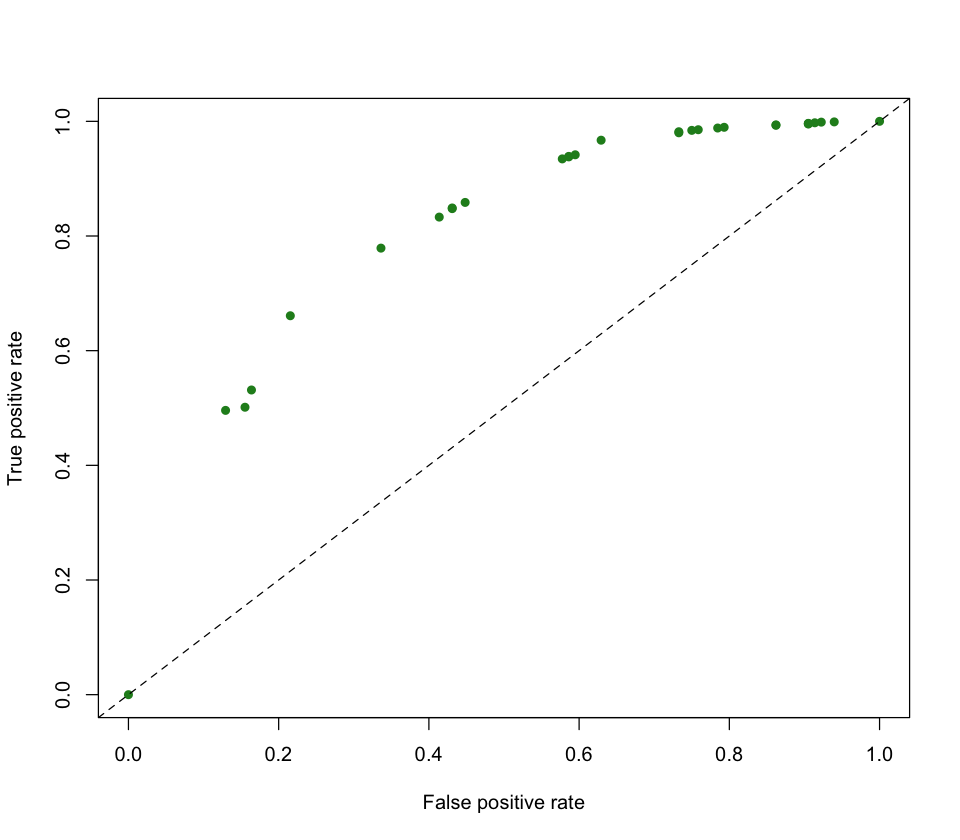

In [32]:


pred_test <- prediction(predict(modello_nonsme$model, dt_pred_tree, type="prob")[, 2], dt_pred_tree$target)

auc_ROCR <- performance(pred_test, measure = "auc")
print(auc_ROCR@y.values[[1]])

# plot(performance(pred_test, measure = "tpr", x.measure = "fpr"),)
# abline(0, 1, lty = 2)
#png('plot_nonsme.jpg')
plot(x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="p", pch = 16,col = 'forestgreen',ylab = 'True positive rate',xlab = 'False positive rate')
abline(0,1, lty = 2)
#dev.off()

Loading required package: pracma

Warning message:
“package ‘pracma’ was built under R version 4.0.5”

Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




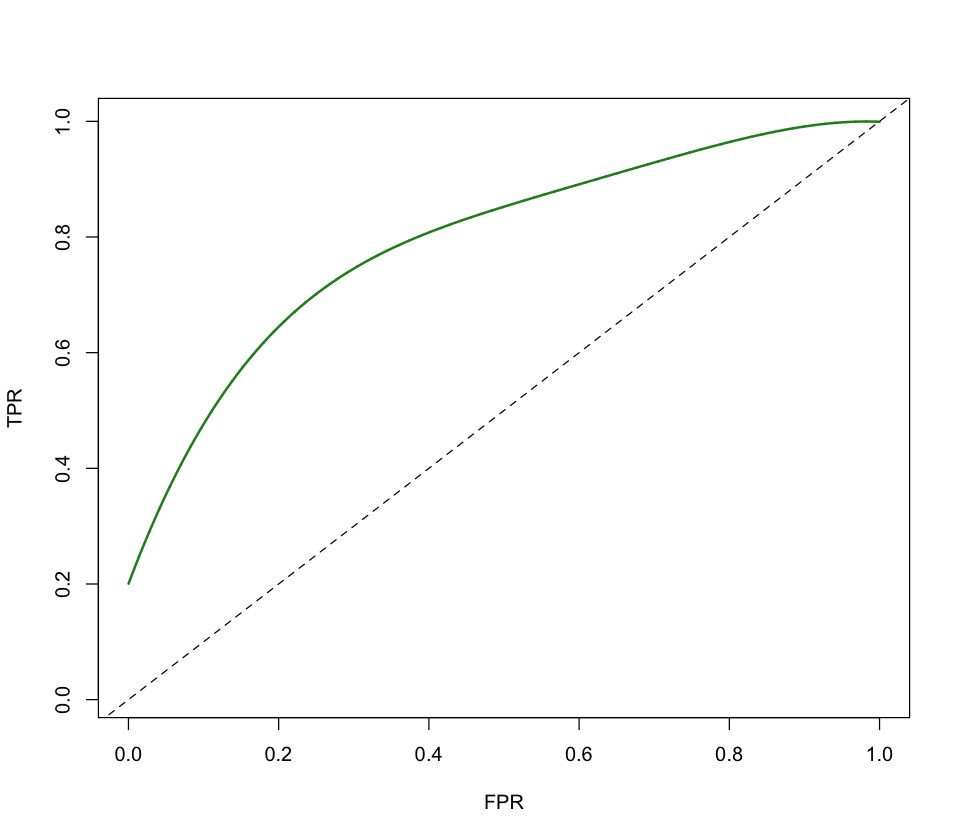

In [33]:
require(pracma)

rocvalues<-function(predictions, results, type=c("roc","gain")) {
	type<-match.arg(type)
	indici<-order(predictions,decreasing=TRUE)
	vec<-results[indici]
	y<-cumsum(vec)/sum(results) #cumulative positive rate
	if (type=="gain") x<-seq_along(results)/length(results) else x<-cumsum(!vec)/sum(!vec) #percentage of sample
	ritorno<-list(x=x,y=y)
	attr(ritorno,"AUC")<-trapz(x,y)
	ritorno
}

test <- dt_sample
test[,target2:=ifelse(target=="DEFAULT",1,0)]
roc <-rocvalues(test$pred_vpc, test$target2,type = 'roc')


rocDT<-data.table(x=roc$x, y=roc$y)
plot(roc$x, roc$y, cex=.1, col='white',pch=15, xlab = 'FPR', ylab = 'TPR')

fit4 <- lm(y~poly(x,4,raw=TRUE), data=rocDT)
fit5 <- lm(y~poly(x,5,raw=TRUE), data=rocDT)
fit6 <- lm(y~poly(x,6,raw=TRUE), data=rocDT)


x_axis <- seq_along(test$target2)/length(test$target2)
#lines(x_axis, predict(fit4, data.frame(x=x_axis)), col='green', lwd=2)
lines(x_axis, predict(fit5, data.frame(x=x_axis)), col='forestgreen', lwd=2)
#lines(x_axis, predict(fit6, data.frame(x=x_axis)), col='blue', lwd=2)
abline(0,1, lty = 2)



### TEST OVERFITTING

[1] 0.8466418


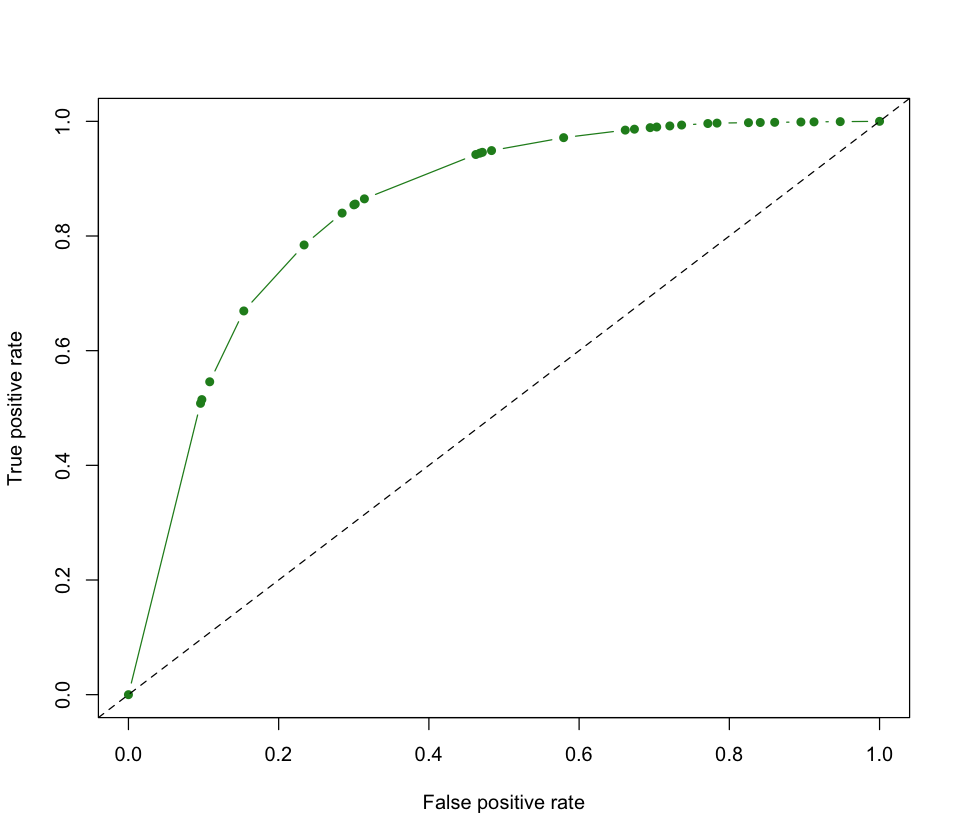

In [34]:
train <-  master_modello_fill[flag_exante == 'NO',..cols_modello][modello_nonsme$rows,]

pred_test <- prediction(predict(modello_nonsme$model, train, type="prob")[, 2], train$target)

auc_ROCR <- performance(pred_test, measure = "auc")
print(auc_ROCR@y.values[[1]])

# plot(performance(pred_test, measure = "tpr", x.measure = "fpr"),)
# abline(0, 1, lty = 2)
#png('plot_nonsme.jpg')
plot(x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="b", pch = 16,col = 'forestgreen',ylab = 'True positive rate',xlab = 'False positive rate')
abline(0,1, lty = 2)
#dev.off()

## PERFORMANCE E LIMITI SOCIETARI

In [35]:
# dt_sample_small <- merge(dt_sample[,.(ESITO_FINALE_VPC,pred_vpc,target,NUM_PRATICA, PROGRESS_PRATICA)],
#                          master_modello[,.(NUM_PRATICA,PROGRESS_PRATICA,DSI_importo_fido_richiesto, DSI_sab,RAT_classe_rating_filt)],
#                          by = c('NUM_PRATICA','PROGRESS_PRATICA'),
#                          all.x = TRUE)

# dt_sample_small[, col_new_vpc := "giallo"]
# dt_sample_small[pred_vpc <= soglia_vg, col_new_vpc := "verde"]
# dt_sample_small[pred_vpc > soglia_gr, col_new_vpc := "rosso"]

# tab_perf <- table_soglie(dt_tree[type != 'other',],soglie = c(soglia_vg,soglia_gr))
# setnames(tab_perf, c('DEFAULT',"OK","tot","perc"),paste0("new_", c('default',"ok","tot","perc"))) 

# old_perf <-  performance_oldvpc(dt_sample)
# setnames(old_perf, c('DEFAULT',"OK"),paste0("old_", c('default',"ok"))) 
# old_perf

# nrow(dt_sample_small[col_new_vpc == 'verde',])

# perf_raw <- merge(tab_perf,
#       old_perf,
#       by = 'colore')
# perf_raw

# dt_sample_limsoc <- merge(dt_sample_small,
#                          dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,LIMITE_MAX,`Esito - LIMITI SOCIETARI`,`Colore - LIMITI SOCIETARI`, `Esito_final_giallo e Monocontrollo_giallo`)],
#                          by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
#                          all.x = TRUE)

# ### NUOVI LIMITI SOCIETARI

# dt_sample_limsoc[,new_limiti := LIMITE_MAX]
# dt_sample_limsoc[grepl("I",RAT_classe_rating_filt),new_limiti := 500000]

# dt_sample_limsoc[DSI_importo_fido_richiesto >new_limiti ,new_col_limiti := "GIALLO"]
# dt_sample_limsoc[DSI_importo_fido_richiesto <= new_limiti ,new_col_limiti := "VERDE"]
# dt_sample_limsoc[LIMITE_MAX == 0 ,new_col_limiti := "ROSSO"]
# dt_sample_limsoc[DSI_importo_fido_richiesto == 0 ,new_col_limiti := "VERDE"]
# dt_sample_limsoc[grepl("R",RAT_classe_rating_filt) & RAT_classe_rating_filt!= 'UR',new_col_limiti := "ROSSO"]


# perf_ls <- copy(perf_raw)

# perf_ls[colore == "GIALLO", 
#         old_default := old_default - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & target == "DEFAULT",]))]

# perf_ls[colore == "GIALLO", old_ok := old_ok - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & target == "OK",]))]

# perf_ls[,old_tot := old_default+old_ok]

# perf_ls[,old_perc := round(100*old_default/old_tot,2)]

# new_g_da_v_ok <- nrow(dt_sample_limsoc[col_new_vpc == 'verde' &`Colore - LIMITI SOCIETARI` == "GIALLO" & target == "OK",])

# new_g_da_v_default<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' &`Colore - LIMITI SOCIETARI` == "GIALLO" & target == "DEFAULT",])

# new_r_da_v_ok<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' &`Colore - LIMITI SOCIETARI` == "ROSSO" & target == "OK",])

# new_r_da_v_default<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' &`Colore - LIMITI SOCIETARI` == "ROSSO" & target == "DEFAULT",])

# new_r_da_g_ok<- nrow(dt_sample_limsoc[col_new_vpc == 'giallo' &`Colore - LIMITI SOCIETARI` == "ROSSO" & target == "OK",])

# new_r_da_g_default<- nrow(dt_sample_limsoc[col_new_vpc == 'giallo' &`Colore - LIMITI SOCIETARI` == "ROSSO" & target == "DEFAULT",])

# perf_ls[colore == "GIALLO", new_default := new_default -new_r_da_g_default + new_g_da_v_default]
# perf_ls[colore == "GIALLO", new_ok := new_ok - new_r_da_g_ok + new_g_da_v_ok]

# perf_ls[colore == "VERDE", new_default := new_default - new_r_da_v_default - new_g_da_v_default]
# perf_ls[colore == "VERDE", new_ok := new_ok  - new_r_da_v_ok - new_g_da_v_ok ]

# perf_ls[colore == "ROSSO", new_default := new_default  + new_r_da_g_default + new_r_da_v_default]
# perf_ls[colore == "ROSSO", new_ok := new_ok + new_r_da_g_ok + new_r_da_v_ok ]

# perf_ls[,new_tot := new_default+new_ok]
# perf_ls[,new_perc := round(100*new_default/new_tot,2)]

# perf_ls

# perf_new_ls <- copy(perf_raw)

# perf_new_ls[colore == "GIALLO", 
#         old_default := old_default - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & target == "DEFAULT" & new_col_limiti == "GIALLO",]))]

# perf_new_ls[colore == "GIALLO", old_ok := old_ok - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & new_col_limiti == "GIALLO" & target == "OK",]))]


# perf_new_ls[colore == "VERDE", 
#         old_default := old_default - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & target == "DEFAULT" & new_col_limiti == "VERDE",]))]

# perf_new_ls[colore == "VERDE", old_ok := old_ok - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & new_col_limiti == "VERDE" & target == "OK",]))]


# perf_new_ls[colore == "ROSSO", 
#         old_default := old_default - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & target == "DEFAULT" & new_col_limiti == "ROSSO",]))]

# perf_new_ls[colore == "ROSSO", old_ok := old_ok - (nrow(dt_sample_limsoc[grepl('LIMITI',`Esito_final_giallo e Monocontrollo_giallo`) & new_col_limiti == "ROSSO" & target == "OK",]))]



# perf_new_ls[,old_tot := old_default+old_ok]

# perf_new_ls[,old_perc := round(100*old_default/old_tot,2)]

# new_g_da_v_ok <- nrow(dt_sample_limsoc[col_new_vpc == 'verde' & new_col_limiti == "GIALLO" & target == "OK",])

# new_g_da_v_default<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' & new_col_limiti == "GIALLO" & target == "DEFAULT",])

# new_r_da_v_ok<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' & new_col_limiti == "ROSSO" & target == "OK",])

# new_r_da_v_default<- nrow(dt_sample_limsoc[col_new_vpc == 'verde' & new_col_limiti == "ROSSO" & target == "DEFAULT",])

# new_r_da_g_ok<- nrow(dt_sample_limsoc[col_new_vpc == 'giallo' & new_col_limiti == "ROSSO" & target == "OK",])

# new_r_da_g_default<- nrow(dt_sample_limsoc[col_new_vpc == 'giallo' & new_col_limiti == "ROSSO" & target == "DEFAULT",])

# perf_new_ls[colore == "GIALLO", new_default := new_default -new_r_da_g_default + new_g_da_v_default]
# perf_new_ls[colore == "GIALLO", new_ok := new_ok - new_r_da_g_ok + new_g_da_v_ok]

# perf_new_ls[colore == "VERDE", new_default := new_default - new_r_da_v_default - new_g_da_v_default]
# perf_new_ls[colore == "VERDE", new_ok := new_ok  - new_r_da_v_ok - new_g_da_v_ok ]

# perf_new_ls[colore == "ROSSO", new_default := new_default  + new_r_da_g_default + new_r_da_v_default]
# perf_new_ls[colore == "ROSSO", new_ok := new_ok + new_r_da_g_ok + new_r_da_v_ok ]

# perf_new_ls[,new_tot := new_default+new_ok]
# perf_new_ls[,new_perc := round(100*new_default/new_tot,2)]

# perf_new_ls

In [36]:
# colnames(dt_sample_limsoc)

# cols_color <- c(colnames(dt_orig)[grepl("Colore -",colnames(dt_orig)) & !grepl('LIMITI SOCIETARI',colnames(dt_orig))])
# #cols_color

# dt_color <- dt_orig[,c("NUM_PRATICA","PROGRESS_PRATICA","ESITO_FINALE_VPC",cols_color), with = FALSE]

# dt_color[, (cols_color) := lapply(dt_color[,cols_color, with = FALSE], function(col){
#         as.numeric(factor(col, levels = c('NERO','GRIGIO','VERDE','GIALLO','ROSSO')))
# })]

# dt_color[, col_senzalimiti := do.call(pmax, c(.SD, list(na.rm = TRUE))), .SDcols=cols_color]

# dt_sample_limsoc <- merge(dt_sample_limsoc,
#                          dt_color[, c("NUM_PRATICA","PROGRESS_PRATICA",'col_senzalimiti')],
#                          by = c("NUM_PRATICA","PROGRESS_PRATICA"),
#                          all.x = TRUE)

# dt_sample_limsoc[col_senzalimiti ==3, colore_senza_limsoc := "VERDE"]
# dt_sample_limsoc[col_senzalimiti ==4, colore_senza_limsoc := "GIALLO"]
# dt_sample_limsoc[col_senzalimiti ==5, colore_senza_limsoc := "ROSSO"]

# colnames(dt_sample_limsoc)

# dt_test_lim_soc <- dt_sample_limsoc[,.(NUM_PRATICA,PROGRESS_PRATICA,ESITO_FINALE_VPC,pred_vpc,target,`Colore - LIMITI SOCIETARI`,new_col_limiti,colore_senza_limsoc)]

# #dt_sample_limsoc[ESITO_FINALE_VPC == "VERDE" & colore_senza_limsoc =="GIALLO",]
# table(dt_sample_limsoc$ESITO_FINALE_VPC)
# table(dt_sample_limsoc$colore_senza_limsoc)





# write.csv(dt_test_lim_soc,'dt_test_lim_soc_co.csv',row.names = FALSE)

# colnames(dt_orig)

## PERFORMANCE SLIDE 

In [37]:
table_performance <- dt_tree[,.(pred_vpc,DEFAULT,OK,tot)]
table_performance[, tot_verdi := round(100*cumsum(tot)/sum(tot),2)]
table_performance[, lift_verde := round((cumsum(DEFAULT)/cumsum(tot))/(sum(DEFAULT)/sum(tot)),2)]
table_performance <- table_performance[order(-pred_vpc)]

table_performance[,td_foglia := round(100*DEFAULT/tot,2)]
table_performance[,def_cum := cumsum(DEFAULT)]
table_performance[,ok_cum := cumsum(OK)]
table_performance[,tot_cum := cumsum(tot)]


#table_performance[,td_cum := def_cum/tot_cum]

table_performance[,recall := round(100*(def_cum-DEFAULT)/sum(DEFAULT),2)]
table_performance[,precision :=  round(100*def_cum/tot_cum,2)]
table_performance[,accuracy :=  round(100*(def_cum+sum(OK) - ok_cum)/sum(tot),2)]
table_performance[,lift := round((def_cum/tot_cum)/(sum(DEFAULT)/sum(tot)),2)]

write.xlsx(table_performance, 'table_performance_corporate.xlsx', row.names= FALSE)

cat('tot default',sum(table_performance$DEFAULT))
cat('\ntot ok',sum(table_performance$OK))
cat('\ntot ',sum(table_performance$tot))
cat('\ntd ',round(100*sum(table_performance$DEFAULT)/sum(table_performance$tot),2))
table_performance[,pred_vpc := as.numeric(pred_vpc)]
table_performance

tot default 116
tot ok 7113
tot  7229
td  1.6

pred_vpc,DEFAULT,OK,tot,tot_verdi,lift_verde,td_foglia,def_cum,ok_cum,tot_cum,recall,precision,accuracy,lift
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0.666666667,7,7,14,100.00,1.00,50.00,7,7,14,0.00,50.00,98.40,31.16
0.625000000,2,3,5,99.81,0.94,40.00,9,10,19,6.03,47.37,98.38,29.52
0.588235294,1,8,9,99.74,0.92,11.11,10,18,28,7.76,35.71,98.28,22.26
0.571428571,1,7,8,99.61,0.92,12.50,11,25,36,8.62,30.56,98.20,19.04
0.550000000,0,4,4,99.50,0.91,0.00,11,29,40,9.48,27.50,98.15,17.14
0.529411765,0,4,4,99.45,0.91,0.00,11,33,44,9.48,25.00,98.09,15.58
0.521739130,5,11,16,99.39,0.91,31.25,16,44,60,9.48,26.67,98.01,16.62
0.259259259,0,5,5,99.17,0.87,0.00,16,49,65,13.79,24.62,97.94,15.34
0.208333333,8,25,33,99.10,0.87,24.24,24,74,98,13.79,24.49,97.70,15.26


In [38]:
performance_prelim <- function(dt){
    rbindlist(lapply(c("VERDE","GIALLO","ROSSO"),function(x){
       dt_appo <- dt[colore_senza_limsoc == x,
                 list(colore = x,
                      DEFAULT = nrow(dt[target=='DEFAULT' &colore_senza_limsoc==x ,]),
                      OK = nrow(dt[target=='OK' &colore_senza_limsoc==x ,]),
                      old_tot = nrow(dt[colore_senza_limsoc==x ,]))]
              dt_appo[,old_td := round(100*DEFAULT/old_tot,3)]
       dt_appo[,sample_perc := round(100*old_tot/nrow(dt),3)]
       })
   )
}


performance_newlim <- function(dt){
    rbindlist(lapply(c("VERDE","GIALLO","ROSSO"),function(x){
       dt_appo <- dt[esito_finale_new_lim == x,
                 list(colore = x,
                      DEFAULT = nrow(dt[target=='DEFAULT' &esito_finale_new_lim==x ,]),
                      OK = nrow(dt[target=='OK' &esito_finale_new_lim==x ,]),
                      old_tot = nrow(dt[esito_finale_new_lim==x ,]))]
              dt_appo[,old_td := round(100*DEFAULT/old_tot,3)]
       dt_appo[,sample_perc := round(100*old_tot/nrow(dt),3)]
       })
   )
}

In [39]:
soglia_vg <- 0.02
soglia_gr <- 0.05

dt_sample_small <- merge(dt_sample[,.(ESITO_FINALE_VPC,pred_vpc,target,NUM_PRATICA, PROGRESS_PRATICA)],
                         master_modello[,.(NUM_PRATICA,PROGRESS_PRATICA,DSI_importo_fido_richiesto, DSI_sab,RAT_classe_rating_filt)],
                         by = c('NUM_PRATICA','PROGRESS_PRATICA'),
                         all.x = TRUE)

dt_sample_small[, col_new_vpc := "giallo"]
dt_sample_small[pred_vpc <= soglia_vg, col_new_vpc := "verde"]
dt_sample_small[pred_vpc > soglia_gr, col_new_vpc := "rosso"]

tab_perf <- table_soglie(dt_tree[type != 'other',],soglie = c(soglia_vg,soglia_gr))
setnames(tab_perf, c('DEFAULT',"OK","tot","perc"),paste0("new_", c('default',"ok","tot","perc"))) 

                               soglia DEFAULT   OK  tot  perc sample_perc
1:                   pred_vpc <= 0.02      48 5925 5973 0.804      82.626
2: pred_vpc <= 0.05 & pred_vpc > 0.02      20  753  773 2.587      10.693
3:                    pred_vpc > 0.05      48  435  483 9.938       6.681
   colore
1:  VERDE
2: GIALLO
3:  ROSSO


In [40]:
# old_perf <-  performance_oldvpc(dt_sample)
# setnames(old_perf, c('DEFAULT',"OK"),paste0("old_", c('default',"ok"))) 
# #old_perf

# nrow(dt_sample_small[col_new_vpc == 'verde',])

# perf_raw <- merge(tab_perf,
#       old_perf,
#       by = 'colore')
# perf_raw

In [42]:
dt_sample_limsoc <- merge(dt_sample_small,
                         dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,LIMITE_MAX,`Esito - LIMITI SOCIETARI`,`Colore - LIMITI SOCIETARI`, `Esito_final_giallo e Monocontrollo_giallo`)],
                         by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
                         all.x = TRUE)

dt_sample_limsoc[,new_limiti := LIMITE_MAX]
dt_sample_limsoc[grepl("I",RAT_classe_rating_filt),new_limiti := 500000]

dt_sample_limsoc[DSI_importo_fido_richiesto >new_limiti ,new_col_limiti := "GIALLO"]
dt_sample_limsoc[DSI_importo_fido_richiesto <= new_limiti ,new_col_limiti := "VERDE"]
dt_sample_limsoc[LIMITE_MAX == 0 ,new_col_limiti := "ROSSO"]
dt_sample_limsoc[DSI_importo_fido_richiesto == 0 ,new_col_limiti := "VERDE"]
dt_sample_limsoc[grepl("R",RAT_classe_rating_filt) & RAT_classe_rating_filt!= 'UR',new_col_limiti := "ROSSO"]


cols_color <- c(colnames(dt_orig)[grepl("Colore -",colnames(dt_orig)) & !grepl('LIMITI SOCIETARI',colnames(dt_orig))])

 dt_sample_limsoc <- merge(dt_sample_limsoc,
                          dt_orig[, c("NUM_PRATICA","PROGRESS_PRATICA",cols_color), with = FALSE],
                          by =  c("NUM_PRATICA","PROGRESS_PRATICA"),
                           all.x = TRUE)

dt_sample_limsoc[, new_num_limiti := as.numeric(factor(new_col_limiti, levels = c('NERO','GRIGIO','VERDE','GIALLO','ROSSO')))]




dt_color <- dt_orig[,c("NUM_PRATICA","PROGRESS_PRATICA","ESITO_FINALE_VPC",cols_color), with = FALSE]

dt_color[, (cols_color) := lapply(dt_color[,cols_color, with = FALSE], function(col){
        as.numeric(factor(col, levels = c('NERO','GRIGIO','VERDE','GIALLO','ROSSO')))
})]

dt_color[, col_senzalimiti := do.call(pmax, c(.SD, list(na.rm = TRUE))), .SDcols=cols_color]




dt_sample_limsoc <- merge(dt_sample_limsoc,
                         dt_color[, c("NUM_PRATICA","PROGRESS_PRATICA",'col_senzalimiti')],
                         by = c("NUM_PRATICA","PROGRESS_PRATICA"),
                         all.x = TRUE)
dt_sample_limsoc[col_senzalimiti ==3, colore_senza_limsoc := "VERDE"]
dt_sample_limsoc[col_senzalimiti ==4, colore_senza_limsoc := "GIALLO"]
dt_sample_limsoc[col_senzalimiti ==5, colore_senza_limsoc := "ROSSO"]
dt_sample_limsoc[is.na(col_senzalimiti), colore_senza_limsoc := ESITO_FINALE_VPC]
dt_sample_limsoc[is.na(col_senzalimiti), col_senzalimiti := 0]

dt_sample_limsoc[, esito_finale_new_lim_num := do.call(pmax, c(.SD, list(na.rm = TRUE))), .SDcols=c('col_senzalimiti','new_num_limiti')]

dt_sample_limsoc[esito_finale_new_lim_num ==3, esito_finale_new_lim := "VERDE"]
dt_sample_limsoc[esito_finale_new_lim_num ==4, esito_finale_new_lim := "GIALLO"]
dt_sample_limsoc[esito_finale_new_lim_num ==5, esito_finale_new_lim := "ROSSO"]
dt_sample_limsoc[esito_finale_new_lim_num ==0, esito_finale_new_lim := ESITO_FINALE_VPC]

In [43]:

performance_oldvpc(dt_sample_limsoc)
performance_prelim(dt_sample_limsoc)

colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,52,3401,3453,1.506,47.766
GIALLO,38,3048,3086,1.231,42.689
ROSSO,26,664,690,3.768,9.545


colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,72,4157,4229,1.703,58.500
GIALLO,24,2449,2473,0.970,34.209
ROSSO,20,507,527,3.795,7.290


In [44]:
performance_newlim(dt_sample_limsoc)

colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,52,3393,3445,1.509,47.655
GIALLO,27,2816,2843,0.950,39.328
ROSSO,37,904,941,3.932,13.017


In [45]:
soglie <- c(0.015,0.04)
rbindlist(lapply(soglie,function(soglia){
    dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
    dt_appo[, tree_col_num := 3]
    dt_appo[pred_vpc > soglia, tree_col_num := 5]
    dt_appo[, col_new_limsoc := do.call(pmax, 
                                        c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
    dt_appo[,colore := "VERDE"]
    dt_appo[col_new_limsoc >3,colore := "ROSSO"]
    dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                          OK = sum(target == "OK"),tot = .N), by ='colore']
    dt_out[,soglia := soglia]
    dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
    dt_out[,td := round(100*DEFAULT/tot,2)]

}))

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
VERDE,21,3951,3972,0.015,54.95,0.53
ROSSO,95,3162,3257,0.015,45.05,2.92
VERDE,34,4581,4615,0.040,63.84,0.74
ROSSO,82,2532,2614,0.040,36.16,3.14


In [46]:
table_soglie(dt_tree,soglie = c(0.015,0.015))

              soglia DEFAULT   OK  tot  perc sample_perc colore
1: pred_vpc <= 0.015      39 5540 5579 0.699      77.175  VERDE
2:  pred_vpc > 0.015      77 1573 1650 4.667      22.825  ROSSO


soglia,DEFAULT,OK,tot,perc,sample_perc,colore
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
pred_vpc <= 0.015,39,5540,5579,0.699,77.175,VERDE
pred_vpc > 0.015,77,1573,1650,4.667,22.825,ROSSO


In [47]:
dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
    dt_appo[, tree_col_num := 3]
    dt_appo[pred_vpc > 0.02 & pred_vpc <=0.04 , tree_col_num := 4]
    dt_appo[pred_vpc > 0.04 , tree_col_num := 5]
    dt_appo[, col_new_limsoc := do.call(pmax, 
                                        c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
    dt_appo[,colore := "VERDE"]
    dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
    dt_appo[col_new_limsoc == 5,colore := "ROSSO"]
    dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                          OK = sum(target == "OK"),tot = .N), by ='colore']
   # dt_out[,soglia := soglia]
    dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
    dt_out[,td := round(100*DEFAULT/tot,2)]

dt_out

colore,DEFAULT,OK,tot,perc_sample,td
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,29,4273,4302,59.51,0.67
GIALLO,19,1920,1939,26.82,0.98
ROSSO,68,920,988,13.67,6.88


In [48]:
soglia_verde <- 0.04
soglie <- c(0.05,0.08,0.017)


performance_0.5 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_0.5

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
VERDE,34,4581,4615,4 % - 5 %,63.84,0.74
GIALLO,15,1633,1648,4 % - 5 %,22.80,0.91
ROSSO,67,899,966,4 % - 5 %,13.36,6.94
VERDE,34,4581,4615,4 % - 8 %,63.84,0.74
GIALLO,20,1823,1843,4 % - 8 %,25.49,1.09
ROSSO,62,709,771,4 % - 8 %,10.67,8.04
VERDE,21,3951,3972,4 % - 1.7 %,54.95,0.53
ROSSO,83,1772,1855,4 % - 1.7 %,25.66,4.47
GIALLO,12,1390,1402,4 % - 1.7 %,19.39,0.86


In [49]:
soglia_verde <- 0.007
soglie <- c(0.009,0.014,0.03)


performance_0.7 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_0.7

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
VERDE,10,2653,2663,0.7 % - 0.9 %,36.84,0.38
GIALLO,11,1916,1927,0.7 % - 0.9 %,26.66,0.57
ROSSO,95,2544,2639,0.7 % - 0.9 %,36.51,3.60
VERDE,10,2653,2663,0.7 % - 1.4 %,36.84,0.38
GIALLO,23,2688,2711,0.7 % - 1.4 %,37.50,0.85
ROSSO,83,1772,1855,0.7 % - 1.4 %,25.66,4.47
VERDE,10,2653,2663,0.7 % - 3 %,36.84,0.38
GIALLO,34,3227,3261,0.7 % - 3 %,45.11,1.04
ROSSO,72,1233,1305,0.7 % - 3 %,18.05,5.52


In [50]:
soglia_verde <- 0.04
soglie <- c(0.07,0.1,0.13)


performance_4 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_4

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
VERDE,34,4581,4615,4 % - 7 %,63.84,0.74
GIALLO,15,1633,1648,4 % - 7 %,22.80,0.91
ROSSO,67,899,966,4 % - 7 %,13.36,6.94
VERDE,34,4581,4615,4 % - 10 %,63.84,0.74
GIALLO,20,1823,1843,4 % - 10 %,25.49,1.09
ROSSO,62,709,771,4 % - 10 %,10.67,8.04
VERDE,34,4581,4615,4 % - 13 %,63.84,0.74
GIALLO,32,1910,1942,4 % - 13 %,26.86,1.65
ROSSO,50,622,672,4 % - 13 %,9.30,7.44


In [51]:
soglia_verde <- 0.12
soglie <- c(0.20,0.25,0.6)


performance_12 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_12

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
VERDE,47,4816,4863,12 % - 20 %,67.27,0.97
GIALLO,20,1724,1744,12 % - 20 %,24.13,1.15
ROSSO,49,573,622,12 % - 20 %,8.60,7.88
VERDE,47,4816,4863,12 % - 25 %,67.27,0.97
GIALLO,28,1749,1777,12 % - 25 %,24.58,1.58
ROSSO,41,548,589,12 % - 25 %,8.15,6.96
VERDE,47,4816,4863,12 % - 60 %,67.27,0.97
GIALLO,35,1785,1820,12 % - 60 %,25.18,1.92
ROSSO,34,512,546,12 % - 60 %,7.55,6.23


In [52]:
write.xlsx(rbind(performance_0.5,performance_4,performance_12), "../non_sme/performance_nuovilimiti_co.xlsx",row.names = FALSE)

In [53]:
soglie <- c(0.005,0.04,0.12)
rbindlist(lapply(soglie,function(soglia){table_soglie(dt_tree,soglie = c(soglia,soglia))}))

              soglia DEFAULT   OK  tot  perc sample_perc colore
1: pred_vpc <= 0.005      15 3527 3542 0.423      48.997  VERDE
2:  pred_vpc > 0.005     101 3586 3687 2.739      51.003  ROSSO
             soglia DEFAULT   OK  tot  perc sample_perc colore
1: pred_vpc <= 0.04      67 6647 6714 0.998      92.876  VERDE
2:  pred_vpc > 0.04      49  466  515 9.515       7.124  ROSSO
             soglia DEFAULT   OK  tot   perc sample_perc colore
1: pred_vpc <= 0.12      85 6971 7056  1.205      97.607  VERDE
2:  pred_vpc > 0.12      31  142  173 17.919       2.393  ROSSO


soglia,DEFAULT,OK,tot,perc,sample_perc,colore
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
pred_vpc <= 0.005,15,3527,3542,0.423,48.997,VERDE
pred_vpc > 0.005,101,3586,3687,2.739,51.003,ROSSO
pred_vpc <= 0.04,67,6647,6714,0.998,92.876,VERDE
pred_vpc > 0.04,49,466,515,9.515,7.124,ROSSO
pred_vpc <= 0.12,85,6971,7056,1.205,97.607,VERDE
pred_vpc > 0.12,31,142,173,17.919,2.393,ROSSO


In [54]:
table(dt_sample$ESITO_FINALE_VPC)


GIALLO  ROSSO  VERDE 
  3086    690   3453 

### PLOT

In [55]:
soglia_vg <- 0.04
soglia_gr <- 0.13

In [56]:

rosso <-   adjustcolor( "red", alpha.f = 0.5)
verde <-   adjustcolor( "darkolivegreen3", alpha.f = 0.6)
giallo <-   adjustcolor( "gold", alpha.f = 0.5)
options(repr.plot.width=8, repr.plot.height=7)
path_name <- create_path('output')
    pdf(file.path(path_name$path,paste0("tree_",path_name$index,'.pdf')))
   prp(modello_nonsme$model, split.fun=split.fun, yesno=1, extra = 105,type = 1, varlen = 0,#box.palette="RdGn",
            box.col=c(verde,giallo,rosso)[findInterval(as.data.table(modello_nonsme$model$frame)$yval2.V4, v = c(0,soglia_vg,soglia_gr))])
   dev.off()

pdf 
  2

### migrazione

In [57]:
## SOGLIE DEFINITIVE

dt_appo <- dt_sample_limsoc[,.(NUM_PRATICA,PROGRESS_PRATICA, pred_vpc,target,ESITO_FINALE_VPC,
                               esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_appo[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,col_new_vpc := "VERDE"]
        dt_appo[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_appo[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

In [58]:
dt_appo<-merge(dt_appo,
              master_modello[, .(NUM_PRATICA,PROGRESS_PRATICA, CRA_ADJ)],
              by = c('NUM_PRATICA','PROGRESS_PRATICA'),
              all.x = TRUE)

dt_appo<-merge(dt_appo,
              dt_orig[, .(NUM_PRATICA,PROGRESS_PRATICA, DATA_DELIBERA_O_ANNULL_FIDO)],
              by = c('NUM_PRATICA','PROGRESS_PRATICA'),
              all.x = TRUE)

In [59]:
colnames(dt_appo)

[1] "NUM_PRATICA"                 "PROGRESS_PRATICA"           
 [3] "pred_vpc"                    "target"                     
 [5] "ESITO_FINALE_VPC"            "esito_finale_new_lim_num"   
 [7] "new_num_limiti"              "col_senzalimiti"            
 [9] "tree_col_num"                "col_new_limsoc"             
[11] "col_new_vpc"                 "CRA_ADJ"                    
[13] "DATA_DELIBERA_O_ANNULL_FIDO"

In [60]:
dt_appo_prelim <- dt_sample_limsoc[,.(pred_vpc,target,ESITO_FINALE_VPC,
                               esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo_prelim[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_appo_prelim[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_appo_prelim[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_appo_prelim[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','tree_col_num')]
        dt_appo_prelim[,col_new_vpc := "VERDE"]
        dt_appo_prelim[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_appo_prelim[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

colnames(dt_appo)

[1] "NUM_PRATICA"                 "PROGRESS_PRATICA"           
 [3] "pred_vpc"                    "target"                     
 [5] "ESITO_FINALE_VPC"            "esito_finale_new_lim_num"   
 [7] "new_num_limiti"              "col_senzalimiti"            
 [9] "tree_col_num"                "col_new_limsoc"             
[11] "col_new_vpc"                 "CRA_ADJ"                    
[13] "DATA_DELIBERA_O_ANNULL_FIDO"

In [61]:
## DEFAULT POST LIM

dt_sam_appo <- dt_appo[target == "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_def <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_def) <- gsub("N\\.","New_",colnames(migr_mat_def))
migr_mat_def <- migr_mat_def[,sort(colnames(migr_mat_def)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_def <- data.frame(migr_mat_def)
rownames(migr_mat_def) <- migr_mat_def$ESITO_FINALE_VPC
migr_mat_def$ESITO_FINALE_VPC <- NULL
migr_mat_def<- cbind(migr_mat_def, total = rowSums(migr_mat_def))
migr_mat_def<- rbind(migr_mat_def, total = colSums(migr_mat_def))
#rownames(migr_mat_def) <- c(migr_mat_def$ESITO_FINALE_VPC,"total")
migr_mat_def

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,20,15,3,38
ROSSO,1,21,4,26
VERDE,11,14,27,52
total,32,50,34,116


In [62]:
## BONIS POST LIM

dt_sam_appo <- dt_appo[target != "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_bon <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_bon) <- gsub("N\\.","New_",colnames(migr_mat_bon))
migr_mat_bon <- migr_mat_bon[,sort(colnames(migr_mat_bon)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_bon <- data.frame(migr_mat_bon)
rownames(migr_mat_bon) <- migr_mat_bon$ESITO_FINALE_VPC
migr_mat_bon$ESITO_FINALE_VPC <- NULL
migr_mat_bon<- cbind(migr_mat_bon, total = rowSums(migr_mat_bon))
migr_mat_bon<- rbind(migr_mat_bon, total = colSums(migr_mat_bon))

migr_mat_bon

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,1662,192,1194,3048
ROSSO,57,342,265,664
VERDE,191,88,3122,3401
total,1910,622,4581,7113


In [63]:
## DEFAULT pre LIM

dt_sam_appo <- dt_appo_prelim[target == "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_def <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_def) <- gsub("N\\.","New_",colnames(migr_mat_def))
migr_mat_def <- migr_mat_def[,sort(colnames(migr_mat_def)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_def <- data.frame(migr_mat_def)
rownames(migr_mat_def) <- migr_mat_def$ESITO_FINALE_VPC
migr_mat_def$ESITO_FINALE_VPC <- NULL
migr_mat_def<- cbind(migr_mat_def, total = rowSums(migr_mat_def))
migr_mat_def<- rbind(migr_mat_def, total = colSums(migr_mat_def))
#rownames(migr_mat_def) <- c(migr_mat_def$ESITO_FINALE_VPC,"total")
migr_mat_def

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,7,9,22,38
ROSSO,1,8,17,26
VERDE,10,14,28,52
total,18,31,67,116


In [64]:
## BONIS pre LIM

dt_sam_appo <- dt_appo_prelim[target != "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_bon <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_bon) <- gsub("N\\.","New_",colnames(migr_mat_bon))
migr_mat_bon <- migr_mat_bon[,sort(colnames(migr_mat_bon)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_bon <- data.frame(migr_mat_bon)
rownames(migr_mat_bon) <- migr_mat_bon$ESITO_FINALE_VPC
migr_mat_bon$ESITO_FINALE_VPC <- NULL
migr_mat_bon<- cbind(migr_mat_bon, total = rowSums(migr_mat_bon))
migr_mat_bon<- rbind(migr_mat_bon, total = colSums(migr_mat_bon))

migr_mat_bon

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,106,46,2896,3048
ROSSO,30,25,609,664
VERDE,188,71,3142,3401
total,324,142,6647,7113


In [65]:
migr_mat_cra <- NULL

In [66]:
dt_cra_appo_def <- dt_appo[target == "DEFAULT",.(N= .N ), by = c('CRA_ADJ','col_new_vpc')]

migr_mat_cra_def <- reshape(dt_cra_appo_def, idvar = "CRA_ADJ", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_cra_def) <- gsub("N\\.","New_",colnames(migr_mat_cra_def))

migr_mat_cra_def <- setDT(migr_mat_cra_def[,sort(colnames(migr_mat_cra_def)), with = FALSE][order(CRA_ADJ)])
migr_mat_cra_def[is.na(CRA_ADJ),CRA_ADJ := 'missing',]

migr_mat_cra_def <- data.frame(migr_mat_cra_def)
rownames(migr_mat_cra_def) <- migr_mat_cra_def$CRA_ADJ
migr_mat_cra_def$CRA_ADJ <- NULL
migr_mat_cra_def<- cbind(migr_mat_cra_def, total = rowSums(migr_mat_cra_def))
migr_mat_cra_def<- rbind(migr_mat_cra_def, total = colSums(migr_mat_cra_def))

migr_mat_cra_def


dt_cra_appo_nondef <- dt_appo[target != "DEFAULT",.(N= .N ), by = c('CRA_ADJ','col_new_vpc')]

migr_mat_cra_nondef <- reshape(dt_cra_appo_nondef, idvar = "CRA_ADJ", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_cra_nondef) <- gsub("N\\.","New_",colnames(migr_mat_cra_nondef))

migr_mat_cra_nondef <- setDT(migr_mat_cra_nondef[,sort(colnames(migr_mat_cra_nondef)), with = FALSE][order(CRA_ADJ)])
migr_mat_cra_nondef[is.na(CRA_ADJ),CRA_ADJ := 'missing',]

migr_mat_cra_nondef <- data.frame(migr_mat_cra_nondef)
rownames(migr_mat_cra_nondef) <- migr_mat_cra_nondef$CRA_ADJ
migr_mat_cra_nondef$CRA_ADJ <- NULL
migr_mat_cra_nondef<- cbind(migr_mat_cra_nondef, total = rowSums(migr_mat_cra_nondef))
migr_mat_cra_nondef<- rbind(migr_mat_cra_nondef, total = colSums(migr_mat_cra_nondef))

migr_mat_cra_nondef

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
00,6,10,13,29
01,5,7,6,18
02,2,18,1,21
03,2,1,NA,NA
04,2,5,2,9
missing,15,9,12,36
total,32,50,NA,NA


,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
00,1060,84,3055,4199
01,339,106,440,885
02,22,253,15,290
03,27,18,41,86
04,76,72,151,299
missing,386,89,879,1354
total,1910,622,4581,7113


In [67]:
# dt_ews_appo <- dt_appo[,.(N= .N ), by = c('EWS_ASIS','col_new_vpc')]

# migr_mat_ews <- reshape(dt_ews_appo, idvar = "EWS_ASIS", timevar = "col_new_vpc", direction = "wide")

# colnames(migr_mat_ews) <- gsub("N\\.","New_",colnames(migr_mat_ews))

# migr_mat_ews <- migr_mat_ews[,sort(colnames(migr_mat_ews)), with = FALSE][order(EWS_ASIS)]

# migr_mat_ews[,EWS_ASIS:= as.character(EWS_ASIS)]
# migr_mat_ews[EWS_ASIS == '0',EWS_ASIS := 'Verde',]
# migr_mat_ews[EWS_ASIS == '1',EWS_ASIS := 'Verdino',]
# migr_mat_ews[EWS_ASIS == '2',EWS_ASIS := 'Arancio',]
# migr_mat_ews[EWS_ASIS == '3',EWS_ASIS := 'Rosso',]
# migr_mat_ews[EWS_ASIS == '4',EWS_ASIS := 'Blu chiaro',]
# migr_mat_ews[EWS_ASIS == '5',EWS_ASIS := 'Blu scuro',]
# migr_mat_ews[is.na(EWS_ASIS),EWS_ASIS := 'missing',]

# migr_mat_ews <- data.frame(migr_mat_ews)
# rownames(migr_mat_ews) <- migr_mat_ews$EWS_ASIS
# migr_mat_ews$EWS_ASIS <- NULL
# migr_mat_ews<- cbind(migr_mat_ews, total = rowSums(migr_mat_ews))
# migr_mat_ews<- rbind(migr_mat_ews, total = colSums(migr_mat_ews))

# migr_mat_ews

In [68]:
dt_appo[,anno := year(DATA_DELIBERA_O_ANNULL_FIDO)]

dt_sam_appo <- dt_appo[,.(N= .N ), by = c('anno','col_new_vpc')]

migr_mat_year <- reshape(dt_sam_appo, idvar = "anno", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_year) <- gsub("N\\.","New_",colnames(migr_mat_year))
migr_mat_year <- migr_mat_year[,sort(colnames(migr_mat_year)), with = FALSE][order(anno)]

migr_mat_year <- data.frame(migr_mat_year)
rownames(migr_mat_year) <- migr_mat_year$anno
migr_mat_year$anno <- NULL
migr_mat_year<- cbind(migr_mat_year, total = rowSums(migr_mat_year))
migr_mat_year<- rbind(migr_mat_year, total = colSums(migr_mat_year))
#rownames(migr_mat_year) <- c(migr_mat_year$ESITO_FINALE_VPC,"total")
migr_mat_year

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
2016,148,103,520,771
2017,458,144,852,1454
2018,544,200,1586,2330
2019,495,149,1110,1754
2020,292,72,518,882
2021,5,4,29,38
total,1942,672,4615,7229


## estrazione soglie di taglio nell'albero

In [69]:
txt <- readr::read_file('output/20220610/tree_nonsme_variabili_isp_V3_arricchito_1.xml')

library(stringr)

In [70]:
##CR
lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=CR_sconf_acc.+/>'))
lista_soglie_cr <- gsub('field=',"",lista_raw)
lista_soglie_cr <- gsub('operator=',"",lista_soglie_cr)
lista_soglie_cr <- gsub('value=',"",lista_soglie_cr)
lista_soglie_cr <- gsub('/>',"",lista_soglie_cr)
lista_soglie_cr <- gsub('greaterOrEqual',">=",lista_soglie_cr)
lista_soglie_cr <- gsub('lessThan',"<",lista_soglie_cr)

data.table(lista_soglie_cr)

lista_soglie_cr
<chr>
CR_sconf_acc >= 0.0172164254269013
CR_sconf_acc < 0.0172164254269013
CR_sconf_acc < -5000
CR_sconf_acc >= 0.152734468722897
CR_sconf_acc < -5000
CR_sconf_acc >= -5000
CR_sconf_acc < 0.152734468722897
CR_sconf_acc >= 1.650634e-06
CR_sconf_acc >= 1.28166848242807e-05


In [71]:
# ##BIL_Oneri_ebitda
# lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=BIL_onerifin_ebitda.+/>'))
# lista_soglie_oneri <- gsub('field=',"",lista_raw)
# lista_soglie_oneri <- gsub('operator=',"",lista_soglie_oneri)
# lista_soglie_oneri <- gsub('value=',"",lista_soglie_oneri)
# lista_soglie_oneri <- gsub('/>',"",lista_soglie_oneri)
# lista_soglie_oneri <- gsub('greaterOrEqual',">=",lista_soglie_oneri)
# lista_soglie_oneri <- gsub('lessThan',"<",lista_soglie_oneri)
# data.table(lista_soglie_oneri)

In [72]:
##BIL_PFN_ebitda
lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=BIL_PFN_Ebitda.+/>'))
lista_soglie_pfn <- gsub('field=',"",lista_raw)
lista_soglie_pfn <- gsub('operator=',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('value=',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('/>',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('greaterOrEqual',">=",lista_soglie_pfn)
lista_soglie_pfn <- gsub('lessThan',"<",lista_soglie_pfn)

data.table(lista_soglie_pfn)

lista_soglie_pfn
<chr>
BIL_PFN_Ebitda < -5000078.6
BIL_PFN_Ebitda >= -5000078.6
BIL_PFN_Ebitda < 0.00675012
BIL_PFN_Ebitda >= -0.6306999
BIL_PFN_Ebitda < -0.630586251275906
BIL_PFN_Ebitda >= -0.630586251275906
BIL_PFN_Ebitda < -0.6306999
BIL_PFN_Ebitda >= 0.00675012
BIL_PFN_Ebitda < 2.51324688978448


#### analisi verdi albero

nome,giallo,rosso
<chr>,<int>,<int>
Colore - SOGGETTO ESTERO,50,0
Colore - TIPO OPERAZIONE RIDUZIO,24,0
Colore - SOGGETTO EEPP,1,0
Colore - FORMA GIURIDICA SENZA C,1,0
Colore - STATO SAB,8,0
Colore - RATING SCADUTO,143,49
Colore - PRESENZA DI FIDI CEDENT,115,0
Colore - SOGGETTO CEDENTE,10,0
Colore - RAPPORTI IN OSSERVAZION,6,0


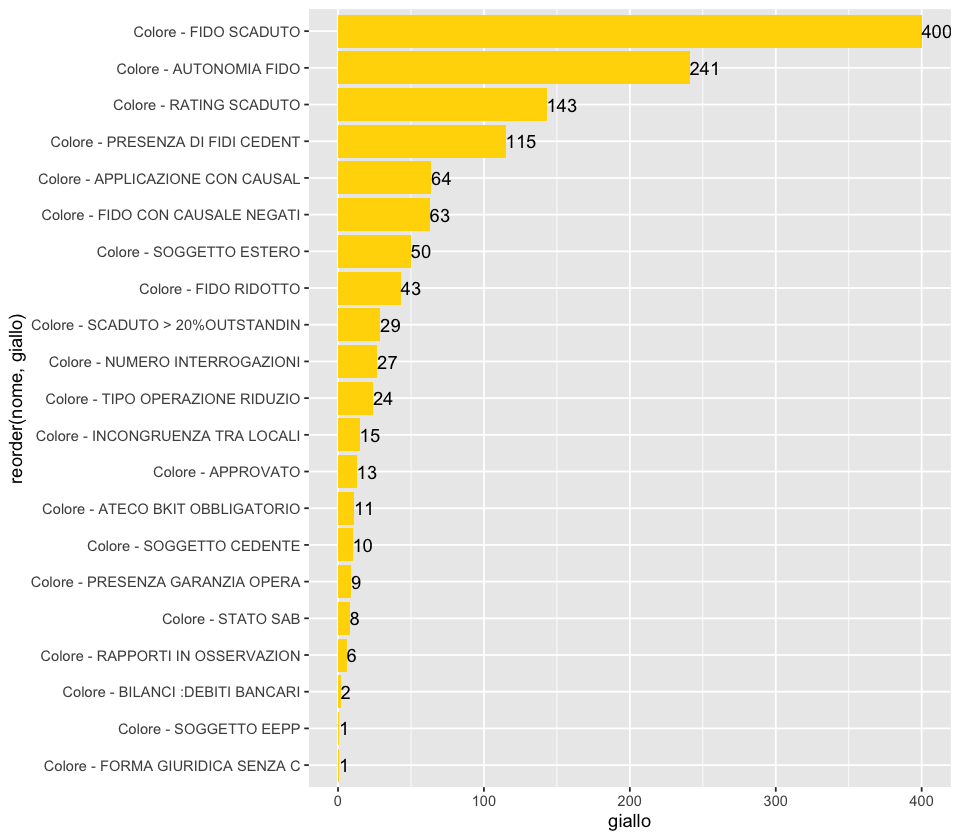

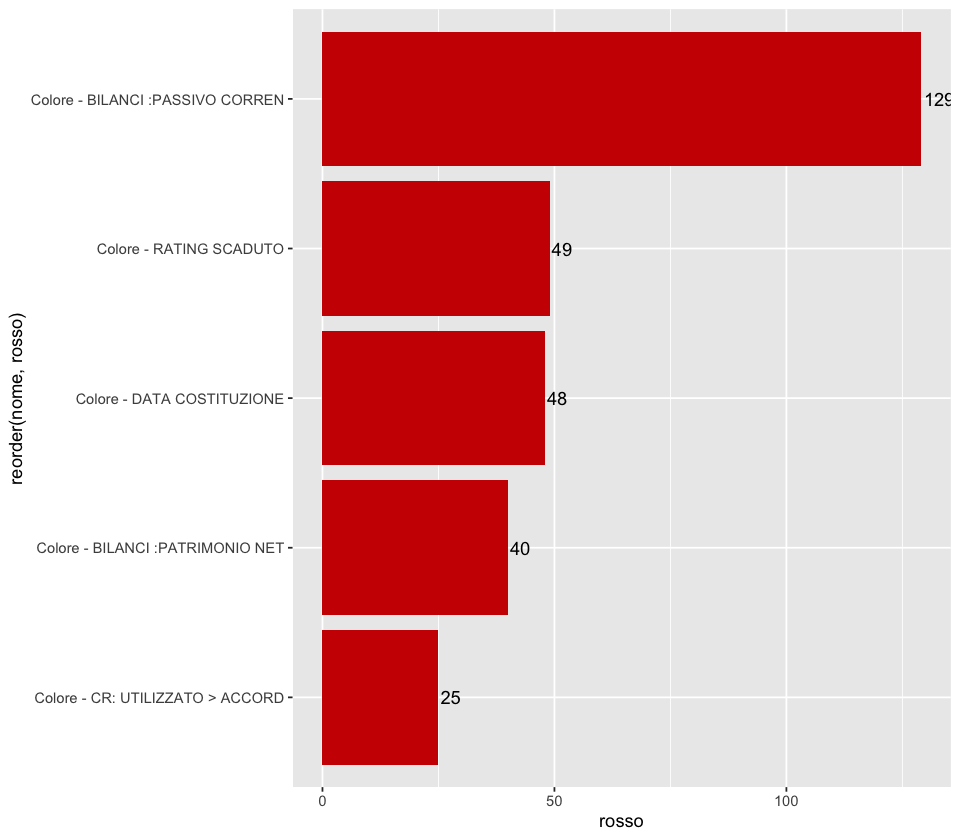

In [73]:
dt_color_conpred <- merge(dt_color,
                          dt_sample_limsoc[,.(NUM_PRATICA,PROGRESS_PRATICA,pred_vpc,target,new_num_limiti)],
                          by = c("NUM_PRATICA","PROGRESS_PRATICA"),
                         all.x = TRUE)

        dt_color_conpred[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_color_conpred[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_color_conpred[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_color_conpred[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_color_conpred[,col_new_vpc := "VERDE"]
        dt_color_conpred[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_color_conpred[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

dt_analisi <- dt_color_conpred[col_new_vpc == "VERDE" & target == "OK" & ESITO_FINALE_VPC != "VERDE" ,..cols_color]

dt_count <- rbindlist(lapply(colnames(dt_analisi), function(col){
    
    data.table(nome = col, giallo = nrow(dt_analisi[get(col)==4,]), rosso = nrow(dt_analisi[get(col)==5,]) )
}))

dt_count[giallo + rosso>0,]

p<-ggplot(data=dt_count[giallo >0,], 
                      aes(x=reorder(nome,giallo), 
                          y=giallo)) + 
                geom_bar(stat="identity", fill="gold") + coord_flip()   +
                geom_text(aes(label=giallo), hjust=0)

            p

ggsave(
                filename = 'analisi_newverdi_bonis_gialli_co.png', 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )

p<-ggplot(data=dt_count[rosso >0,], 
                      aes(x=reorder(nome,rosso), 
                          y=rosso)) + 
                geom_bar(stat="identity", fill="red3") + coord_flip()  +
                geom_text(aes(label=rosso), hjust=-0.1)

            p
ggsave(
                filename = 'analisi_newverdi_bonis_rossi_co.png', 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )

## ESTRAZIONE RAMI PRINCIPALI

In [80]:
model_frame_foglie <- model_frame[ type != "other"]
model_frame_foglie[, perc := round(100*n/sum(n),1)]

dt_esempi <- rbindlist(lapply(unique(dt_sample$pred_vpc), function(s){
    dt <- head(dt_sample[pred_vpc == s,],1)
}))

dt_rules <- setDT(unique(rpart.predict(modello_nonsme$model,newdata= dt_esempi, rules = TRUE)))

colnames(dt_rules) <- c('DEFAULT',"OK","ramo")
dt_rules <- dt_rules[,.(DEFAULT,ramo)]

dt_rules[, nodi := str_count(ramo, "&")+1]
dt_rules[,ramo := gsub("\\s+"," ",ramo)]
dt_rules[,ramo := gsub("&","& ____",ramo)]
dt_rules[,ramo := gsub("____","\n\n",ramo)]


dt_rules <- merge(dt_rules,
                 model_frame_foglie[,.(yval2.V4,perc)],
                 by.x = 'DEFAULT',
                 by.y = 'yval2.V4',
                 all.x = TRUE)

In [88]:
dt_rules[, settore := gsub('\\s+'," ",gsub('[a-z,&]',"",str_extract_all(ramo, "sett is .+&")))]

mapping_settori <- unique(master_modello[,.(AT_sett_desc,AT_cod_sett)])

dt_rules <- rbindlist(lapply((1:nrow(dt_rules)),function(i){
    dt<- dt_rules[i,]
     dt[,settore_desc := paste(unique(mapping_settori[AT_cod_sett %in% unlist(strsplit(settore," ")),AT_sett_desc]),collapse = "; ")]
#     dt
    
}))


In [90]:
write.xlsx(dt_rules[order(-perc)],'tabella_rami_co.xlsx')
dt_rules[order(-perc)]

DEFAULT,ramo,nodi,perc,settore,settore_desc
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0.003804912,because EWS_pred < 0.0351 & CRA_andamento is Migliorato or Peggiorato or Stabile or Volatile & CR_sconf_acc < 1.2e-01 & RAT_classe_rating_filt is I1 or I2 or I3 or I4 or I5 or I6 or M1 or M2 or M3 or R5 or UR & AT_eta_soc >= 15,5,50.0,(0),
0.007371704,because EWS_pred < 0.0351 & CRA_andamento is Migliorato or Peggiorato or Stabile or Volatile & AT_cod_sett is ABCON00 or AEROS00 or ALIMP00 or APMED00 or ASERV00 or ASSIC00 or ATRIC00 or AUTOD00 or AUTOP00 or COMPO00 or DETTA00 or DIFES00 or DUREP00 or ESTRA00 or FARMD00 or FARMP00 or FINSE00 or GIOAZ00 or HARDW00 or HOLDI00 or INFRA00 or LEGNO00 or MACCH00 or MAIMG00 or MAIMS00 or MATCO00 or METAL00 or OILGA00 or POWER00 or PRODM00 or SILVI00 or SOFTW00 or TABAC00 or TELEC00 or TESSP00 or TRASP00 or TRASS00 or TURAL00 or TURRI00 or UTILI00 or missing & CR_sconf_acc < 1.2e-01 & RAT_classe_rating_filt is I1 or I2 or I3 or I4 or I5 or I6 or M1 or M2 or M3 or R5 or UR & AT_eta_soc < 15,6,12.2,ABCON00 AEROS00 ALIMP00 APMED00 ASERV00 ASSIC00 ATRIC00 AUTOD00 AUTOP00 COMPO00 DETTA00 DIFES00 DUREP00 ESTRA00 FARMD00 FARMP00 FINSE00 GIOAZ00 HARDW00 HOLDI00 INFRA00 LEGNO00 MACCH00 MAIMG00 MAIMS00 MATCO00 METAL00 OILGA00 POWER00 PRODM00 SILVI00 SOFTW00 TABAC00 TELEC00 TESSP00 TRASP00 TRASS00 TURAL00 TURRI00 UTILI00,"Macchine per impieghi speciali; Prodotti in metallo; Turismo - Alloggio e Agenzie di viaggio; Tessile, abbigliamento e lusso - Produzione; Farmaceutica e Biotecnologie - Distribuzione; Componenti e apparecchiature elettriche; Macchine per impieghi generali; Altri servizi; Trasporti - Servizi; Apparecchiature medicali; Alimentare e bevande - Produzione; Oil and Gas; Macchinari e altre attrezzature - Ingrosso; Dettaglio - Altro; Software e Servizi IT; Durevoli - Produzione; Metallurgia; Hardware e Semiconduttori; Automotive - Distribuzione; Power Generation; Infrastrutture; Legno e carta; Materiali costruzioni; Turismo - Ristorazione; Farmaceutica e Biotecnologie - Produzione; Automotive - Produzione; Utilities; Difesa; Gioco d'azzardo; Estrazione; Tabacco; Attivita' ricreative; Altri beni di consumo; Holding; Trasporti - Produzione; Telecomunicazioni; Silvicoltura e altre attività forestali; Assicurazioni; Financial services; Aerospace"
0.013905683,because EWS_pred < 0.0662 & CRA_andamento is Cra Grigio nel trimestre or Cra non presente ultimo trimestre or Non presente cra or missing & AT_cod_sett is ABCON00 or AEROS00 or AGRIC00 or ALIMP00 or APMED00 or ASERV00 or ASSIC00 or ATRIC00 or AUTOD00 or AUTOP00 or CHIMI00 or COMPO00 or COSTR00 or DETTA00 or DIFES00 or DURED00 or DUREP00 or FARMD00 or FARMP00 or FINSE00 or GDO00 or GIOAZ00 or HARDW00 or HOLDI00 or IMMOB00 or INFRA00 or INGRO00 or ISTRU00 or LEGNO00 or MACCH00 or MAIMG00 or MAIMS00 or MATCO00 or METAL00 or OILGA00 or POWER00 or PRODM00 or RACTR00 or SERVA00 or SILVI00 or SOFTW00 or TABAC00 or TELEC00 or TESSP00 or TRASP00 or TRASS00 or TURAL00 or TURRI00 or UTILI00 or missing & CR_sconf_acc < 1.7e-06 & BIL_PFN_Ebitda >= 0.0068,5,11.4,ABCON00 AEROS00 AGRIC00 ALIMP00 APMED00 ASERV00 ASSIC00 ATRIC00 AUTOD00 AUTOP00 CHIMI00 COMPO00 COSTR00 DETTA00 DIFES00 DURED00 DUREP00 FARMD00 FARMP00 FINSE00 GDO00 GIOAZ00 HARDW00 HOLDI00 IMMOB00 INFRA00 INGRO00 ISTRU00 LEGNO00 MACCH00 MAIMG00 MAIMS00 MATCO00 METAL00 OILGA00 POWER00 PRODM00 RACTR00 SERVA00 SILVI00 SOFTW00 TABAC00 TELEC00 TESSP00 TRASP00 TRASS00 TURAL00 TURRI00 UTILI00,"Macchine per impieghi speciali; Prodotti in metallo; Turismo - Alloggio e Agenzie di viaggio; Tessile, abbigliamento e lusso - Produzione; Farmaceutica e Biotecnologie - Distribuzione; Componenti e apparecchiature elettriche; Immobiliare; Macchine per impieghi generali; Altri servizi; Costruzioni - Edilizia; Trasporti - Servizi; Chimica, Gomma e Plastica; Apparecchiature medicali; Alimentare e bevande - Produzione; Servizi di assistenza sanitaria; Oil and Gas; GDO; Macchinari e altre attrezzature - Ingrosso; Dettaglio 

## CROSS VALIDATION

In [ ]:
# lista_auc2 <- lapply(c(10311,33433,45343,651194,1244,4222), function(seed){
#     modello_nonsme <- compute_model(
#     master_modello_fill[flag_exante == 'NO',
#    # setdiff(colnames(master_modello_fill),c(lista_vars_na,cols_2rm,"flag_exante")),,with = FALSE
#                        ..cols_modello], seed = seed,
#     suffix="nonsme_variabili_isp_V3_arricchito",minbuck= 0.0003, 
#   # cols_2rm = c("EWS_ASIS",'CRA_ADJ'),
#     use_surr =  1,perc_split = 0.80,desc = 'nonsme')
    
    
#  dt_pred_tree <- merge(modello_nonsme$pred,unique(model_frame[type =='leaf',.(yval2.V4,type)]),by.x ='pred_vpc', by.y = 'yval2.V4', all.x = TRUE )
   

# pred_test <- prediction(predict(modello_nonsme$model, dt_pred_tree, type="prob")[, 2], dt_pred_tree$target)

# auc_ROCR <- performance(pred_test, measure = "auc")
# print(auc_ROCR@y.values[[1]])

# # plot(performance(pred_test, measure = "tpr", x.measure = "fpr"),)
# # abline(0, 1, lty = 2)
# png(paste0('cross_val/plot_nonsme', seed,'.jpg'))
# plot(x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="p", pch = 16,col = 'forestgreen',ylab = 'True positive rate',xlab = 'False positive rate', main=round(auc_ROCR@y.values[[1]],2))
# abline(0,1, lty = 2)
# dev.off()
#     return(auc_ROCR@y.values[[1]])
# })

# names(lista_auc2) <- c(10311,33433,45343,651194,1244,4222)